In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller

In [2]:
df = pd.read_csv("../data/processed/macro_monthly_clean.csv")

df = df.sort_values(["year", "month"]).reset_index(drop=True)
df["date"] = pd.to_datetime(df["period"])

In [3]:
df_var = df[["date", "bi_rate", "inflation"]].set_index("date")
df_var.head()

,bi_rate,inflation
date,,
2016-04-01,5.50,3.60
2016-05-01,5.50,3.33
2016-06-01,5.25,3.45
2016-07-01,5.25,3.21
2016-08-01,5.25,2.79


In [4]:
def adf_test(series, name):
    result = adfuller(series)
    print(f"ADF Test for {name}")
    print(f"ADF Statistic : {result[0]:.3f}")
    print(f"p-value       : {result[1]:.3f}")
    print("-" * 30)

In [5]:
adf_test(df_var["bi_rate"], "BI Rate")
adf_test(df_var["inflation"], "Inflation")

ADF Test for BI Rate
ADF Statistic : -2.116
p-value       : 0.238
------------------------------
ADF Test for Inflation
ADF Statistic : -2.715
p-value       : 0.072
------------------------------


In [6]:
df_var_diff = df_var.diff().dropna()
df_var_diff.head()

,bi_rate,inflation
date,,
2016-05-01,0.00,-0.27
2016-06-01,-0.25,0.12
2016-07-01,0.00,-0.24
2016-08-01,0.00,-0.42
2016-09-01,-0.25,0.28


In [7]:
adf_test(df_var_diff["bi_rate"], "Δ BI Rate")
adf_test(df_var_diff["inflation"], "Δ Inflation")

ADF Test for Δ BI Rate
ADF Statistic : -4.216
p-value       : 0.001
------------------------------
ADF Test for Δ Inflation
ADF Statistic : -4.350
p-value       : 0.000
------------------------------


In [8]:
model = VAR(df_var_diff)

lag_order = model.select_order(maxlags=6)
lag_order.summary()

d:\Personal Files\Portofolio Projects\impact-bi-rate-inflation\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


,AIC,BIC,FPE,HQIC
0,-5.508,-5.459*,0.004054,-5.488
1,-5.558,-5.412,0.003856,-5.499
2,-5.670,-5.426,0.003447,-5.571*
3,-5.709*,-5.367,0.003318*,-5.570
4,-5.639,-5.200,0.003558,-5.461
5,-5.588,-5.051,0.003748,-5.370
6,-5.556,-4.921,0.003874,-5.298


In [9]:
var_model = model.fit(lag_order.selected_orders["aic"])
var_model.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Mon, 09, Feb, 2026
Time:                     20:48:26
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                   -5.37066
Nobs:                     114.000    HQIC:                  -5.57031
Log likelihood:           15.7632    FPE:                 0.00332469
AIC:                     -5.70669    Det(Omega_mle):      0.00295115
--------------------------------------------------------------------
Results for equation bi_rate
                  coefficient       std. error           t-stat            prob
-------------------------------------------------------------------------------
const               -0.000540         0.014440           -0.037           0.970
L1.bi_rate           0.182174         0.096483            1.888           0.059
L1.inflation         0.003516         0.039909            0.08

In [10]:
irf = var_model.irf(12)

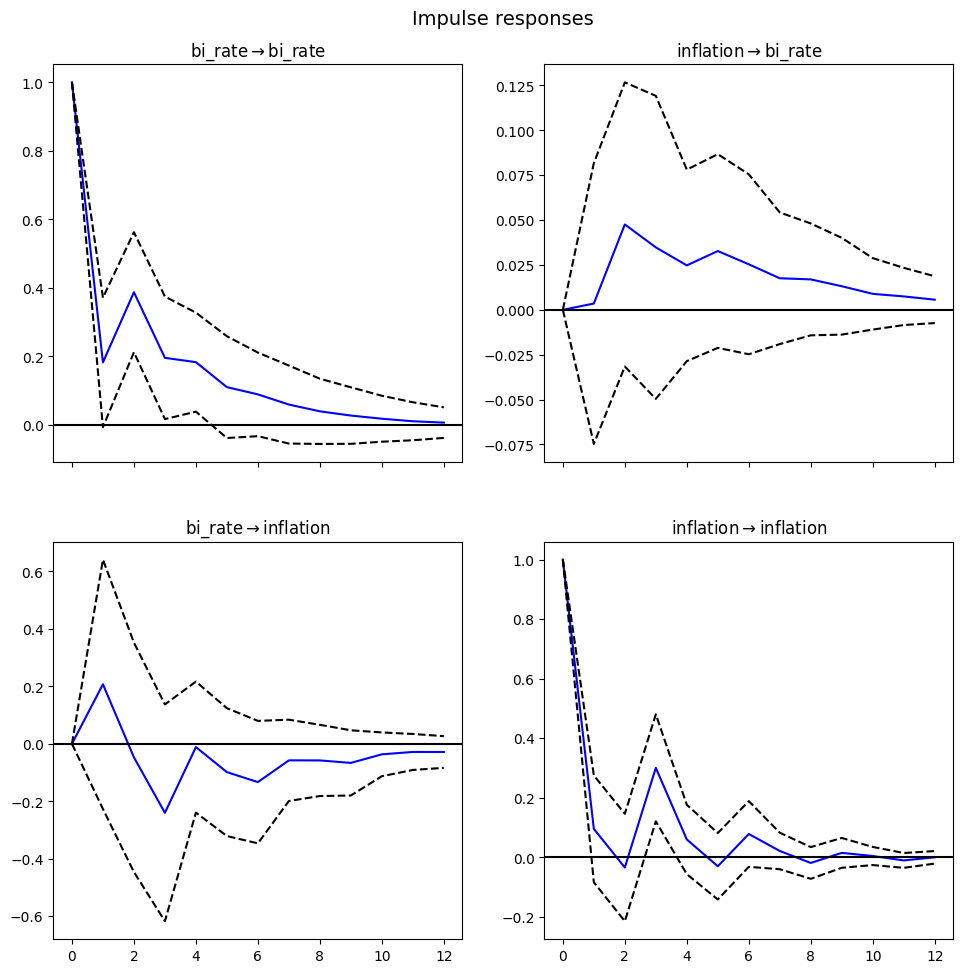

In [17]:
irf.plot(orth=False)
plt.show()

In [12]:
irf_values = irf.irfs

df_irf = pd.DataFrame(
    irf_values[:, :, df_var_diff.columns.get_loc("inflation")],
    columns=df_var_diff.columns
)

df_irf["horizon"] = df_irf.index

df_irf.to_csv(
    "../data/processed/irf_values.csv",
    index=False
)

In [13]:
forecast = var_model.forecast(df_var_diff.values[-var_model.k_ar:], steps=12)

df_forecast = pd.DataFrame(
    forecast,
    columns=df_var_diff.columns
)

df_forecast["horizon"] = range(1, 13)

df_forecast.to_csv(
    "../data/processed/var_forecast.csv",
    index=False
)

### Step 6 — Vector Autoregression (VAR)

This step applies a Vector Autoregression (VAR) model to analyze the dynamic interaction between BI Rate and inflation. 
Both variables are first transformed into stationary series using first differences to ensure valid time-series analysis.

The optimal lag length is selected using information criteria, with the results indicating a lag of three months. 
Impulse Response Function (IRF) analysis shows that inflation does not respond immediately to changes in BI Rate. 
Instead, the response emerges gradually after several months and then diminishes over time.

Overall, the VAR results support earlier findings that the relationship between BI Rate and inflation is dynamic 
and operates with a time lag rather than instantaneously.